In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import numpy as np
from matplotlib import pyplot as plt
import torch
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL
from sparse_causal_model_learner_rl.config import Config
from causal_util import load_env
from tqdm.auto import tqdm
from torch import nn
import gin
from encoder.digit_encoder import small_int_vector_asimage, show_digits, digits
gin.enter_interactive_mode()

In [2]:
load_config_files(['../vectorincrement/config/ve5_toy_digits.gin'])

['ve5_toy_digits']

In [3]:
env = load_env()

Make environment VectorIncrement-v0 None {}


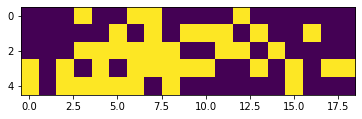

In [4]:
plt.imshow(env.reset())

In [5]:
obss = []
for _ in tqdm(range(100)):
    obss.append(env.reset())
    done = False
    while not done:
        obs, rew, done, info = env.step(env.action_space.sample())
        obss.append(obs)

In [6]:
obss = np.array(obss)

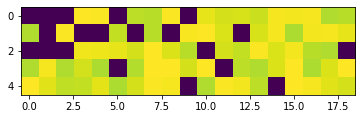

In [7]:
plt.imshow(np.std(obss, axis=0))

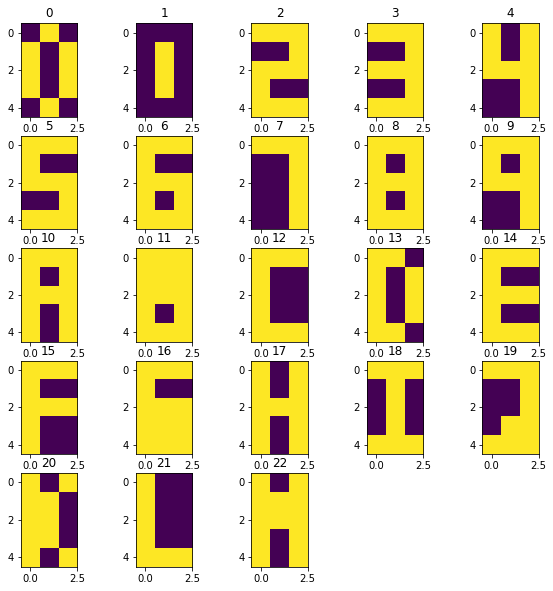

In [10]:
show_digits(digits)

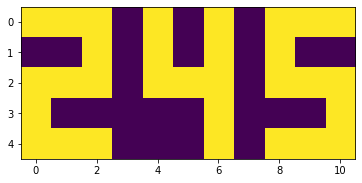

In [11]:
plt.imshow(small_int_vector_asimage([2, 4, 5]))

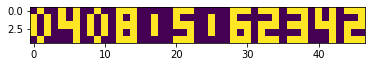

In [12]:
plt.imshow(small_int_vector_asimage([4, 8, 15, 16, 23, 42], max_digits=2))

In [13]:
from IPython.display import clear_output, display
import ipywidgets as widgets
from time import sleep
from PIL import Image
import io

In [14]:
perm = np.random.permutation(np.prod(env.reset().shape))

ck = widgets.Checkbox(
    value=False,
    description='Permute pixels',
    disabled=False,
    indent=False
)

display(ck)

def unpermute_observation(obs):
    return obs.flatten()[np.argsort(env.env.perm)].reshape(obs.shape)

def permute_observation(obs, perm):
    return obs.flatten()[perm].reshape(obs.shape)
    
def npimg_to_png(obs):
    
    obs_rgb = (obs/0.2 * 200).astype(np.uint8).reshape(*obs.shape, 1).repeat(3, axis=2)
    img = Image.fromarray(obs_rgb)
    img = img.resize((obs.shape[1] * 10, obs.shape[0] * 10), Image.NEAREST)
    
    img_byte_arr = io.BytesIO()
    img.convert('RGB').save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr
    
obs = env.reset()

img_widget = widgets.Image(
    value=npimg_to_png(obs),
    format='png',
    width=300,
    height=400,
)
                                       
def show_obs(obs, permute=None):
    obs = unpermute_observation(obs)
    if permute is None:
        permute = ck.value
    if permute:
        obs = permute_observation(obs, perm)
    img_widget.value = npimg_to_png(obs)

show_obs(obs)
done = False

import ipywidgets as widgets
class ClickResponsiveToggleButtons(widgets.ToggleButtons):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._click_handlers = widgets.CallbackDispatcher()
        self.on_msg(self._handle_button_msg)
        pass

    def on_click(self, callback, remove=False):
        """Register a callback to execute when the button is clicked.

        The callback will be called with one argument, the clicked button
        widget instance.

        Parameters
        ----------
        remove: bool (optional)
            Set to true to remove the callback from the list of callbacks.
        """
        self._click_handlers.register_callback(callback, remove=remove)

    def _handle_button_msg(self, _, content, buffers):
        """Handle a msg from the front-end.

        Parameters
        ----------
        content: dict
            Content of the msg.
        """
        if content.get('event', '') == 'click':
            self._click_handlers(self)

options = '01234'

btn = ClickResponsiveToggleButtons(
    options=list(options),
    description='Action:',
    disabled=False,
    button_style='success',
)

info = widgets.HTML(
    value="Hello <b>World</b>",
)
info.value = "Environment reset. <i>Press buttons to take actions</i>"

filled = False
step = 0
def handler(x):
    x = x.index
    if x >= 0:
        global done, obs, filled, step
        filled = True
        action = x
        obs, rew, done, _ = env.step(action)
        info.value = f"<b>Step:</b> {step}<br />" +\
                     f"<b>Reward:</b> {rew}<br />" +\
                     f"<b>{'done' if done else 'Press action to continue'}</b>"
        step += 1
        
#         btn.disabled = done
        btn.button_style = 'warning' if done else 'success'
        show_obs(obs)
        if done:
            sleep(0.5)
            obs = env.reset()
            info.value = "Environment reset. <i>Press buttons to take actions</i>"
            show_obs(obs)
            btn.button_style = 'success'
            step = 0

display(btn)
display(img_widget)
display(info)
btn.on_click(handler)

Checkbox(value=False, description='Permute pixels', indent=False)

ClickResponsiveToggleButtons(button_style='success', description='Action:', options=('0', '1', '2', '3', '4'),…

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xbe\x00\x00\x002\x08\x02\x00\x00\x00md\xf6i\x00\…

HTML(value='Environment reset. <i>Press buttons to take actions</i>')

env

In [30]:
obs = env.reset()
for _ in range(10):
    obs, _, _, _ = env.step(env.action_space.sample())

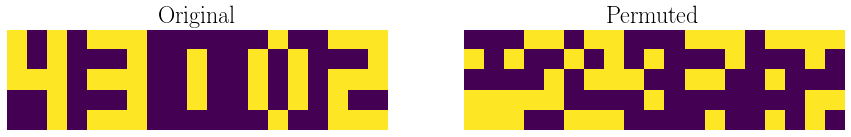

In [36]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 2)
plt.title("Permuted")
plt.imshow(obs)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(unpermute_observation(obs))
plt.axis('off')
plt.savefig('../../ve5_obs.pdf', bbox_inches='tight')

In [34]:
plt.rcParams.update({
    #'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family' : 'normal',
        'font.weight' : 'normal',
        'font.size'   : 20
})


In [37]:
env.reset().shape

(5, 19)